In [153]:
import numpy as np
from scipy import io
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
mat_dict = io.loadmat('test.mat')
test_cl = mat_dict['test_cl']
test_hi = mat_dict['test_hi']
test_lo = mat_dict['test_lo']
test_op = mat_dict['test_op']
test_vol = mat_dict['test_vol']
numDays, numStocks = test_cl.shape
test_stocks = []
for i in range(numStocks):
    test_stocks.append(np.array_str(mat_dict['test_stocks'][0][i])[3:-2])

In [155]:
def uniform_rebalance(t, portfolio_t, hi, lo, cl, op, stocks, vol):
    """% Input: 
    %%% t: we are at Day t
    %%% portfolio_t: current portfolio before open of Day t
    %%% hi: highest prices at Day t-1
    %%% lo: lowest prices at Day t-1
    %%% cl: close prices at Day t-1
    %%% op: open prices at Day t
    %%% stocks: names of all stocks
    %%% vol: volumes at Day t-1

    % Output: 
    %%% portfolio: a column vector, each entry represents the portion of 
    %%%            the value of the corresponding stock over the total cash 
    %%%            realizable value [as a result, the value of inactive stocks 
    %%%            i.e., with open price NaN, cannot be added into the total
    %%%            cash realizable value]. Hence, your output must satisfy
    %%%            sum(portfolio(isfinite(op))) < 1, and the rest is the 
    %%%            portion of cash realizable value you hold in cash. 
    %%% hold_flag: a binary vector representing whether you would like to hold
    %%%            (with value 1) each stock or you choose to rebalance it
    %%%            (with value 0). """
    numStocks = len(stocks)
    portfolio = np.zeros(numStocks)
    numActiveStock = np.sum(np.isfinite(op))
    portfolio[np.isfinite(op)] = 1.0/numActiveStock
    if np.mod(t,2) == 1:
        hold_flag = np.zeros(numStocks,dtype=bool)
    else:
        hold_flag = np.ones(numStocks,dtype=bool)      
    return portfolio, hold_flag

In [156]:
def rebalance(value_vec, value_realizable, portfolio_dst, cost_rate):
    """ % This function simulates the process of rebalancing. The key difficulty 
    % here is to compute the transaction cost, i.e., to solve the equation
    %
    % sum( cost_rate * abs( portfolio_dst .* (value_realizable - C) -
    % value_vec) ) = C
    % 
    % where C is the total transcation cost. We use the Banach contraction 
    % theorem to solve this equation, with convergence rate cost_rate^t for 
    % t-th iteration. 

    % Input: 
    %%% value_vec: current values of each active stock
    %%% value_realizable: total cash realizable value
    %%% portfolio_dst: the desired portfolio after rebalancing
    %%% cost_rate: ratio of transactions cost (0.0005 in our case)

    % Output:
    %%% new_value_vec: the value vector after rebalancing
    %%% trans_cost: the total transaction cost"""
    
    if len(portfolio_dst)==0:
        new_value_vec = value_vec
        trans_cost = 0
    else:
        len_noHold = value_vec.size
        C_candidate = np.append([0], value_realizable - value_vec / portfolio_dst)
        x = np.sort(C_candidate)
        x[np.logical_or(np.isinf(x),np.isnan(x))] = 1e15
        x1 = value_realizable - x
        len_x = len(x1)
        
        y = np.sum(cost_rate * np.abs(np.dot(portfolio_dst.reshape(len_noHold,1),x1.reshape(1,len_x)) \
                  -np.dot(value_vec.reshape(len_noHold,1),np.ones((1,len_x)))), axis=0).squeeze() - x
        I = np.where(y<=0)[0]
        if (len(I)==0) or I[0]==0:
            trans_cost = 0
            new_value_vec = value_vec
        else: #  the equation is linear in [C_sort(I-1), C_sort(I)]           
            I = I[0]
            trans_cost = x[I-1] - y[I-1] * (x[I] - x[I-1]) / (y[I] - y[I-1])
            if trans_cost > value_realizable:
                trans_cost = 0
                new_value_vec = value_vec
            else:
                new_value_vec = portfolio_dst * (value_realizable - trans_cost)
    return new_value_vec, trans_cost

In [157]:
value_op_seq = np.zeros(numDays) # total value before open of each day
value_cl_seq = np.zeros(numDays) # total value before close of each day 
portfolio_seq = np.zeros((numStocks, numDays)) # portfolio before open of each day
last_close_price = np.NaN * np.ones(numStocks)
print numDays, numStocks

1247 497


In [158]:
# Initialization
op = test_op[0,:]
cl = np.NaN * np.ones(numStocks)
hi = np.NaN * np.ones(numStocks)
lo = np.NaN * np.ones(numStocks)
vol = np.NaN * np.ones(numStocks)
value_op_seq[0] = 1 # initially we hvae one unit of cash

In [159]:
for t in range(numDays):
    # At the beginning of day t, we use all information up to the open 
    # price of day t to determine the capital allocation at the end of 
    # day t.
    
    # Your function should be placed here. Note that the input vector may
    # contain NaNs (at Day 1, or for some inactive stocks). 
    new_portfolio, hold_flag = uniform_rebalance(t, portfolio_seq[:,t], hi, lo, cl, op, test_stocks, vol)
    
    # Check whether your output is valid
    isActive = np.isfinite(op)
    noHold = np.logical_and(isActive, np.logical_not(hold_flag))
    if np.sum(new_portfolio[noHold]) > 1 + 1e-8:
        sys.stderr.write('The output portfolio is not valid!')
        
    # The value of our portfolio at the end of Day t before paying transaction costs
    cl = test_cl[t,:]
    value_vec = value_op_seq[t] * portfolio_seq[:,t]
    growth = cl[isActive] / last_close_price[isActive]-1
    growth[np.isnan(growth)] = 0
    revenue_vec = value_vec[isActive] * growth
    value_vec[isActive] = value_vec[isActive] + revenue_vec
    value_cl_seq[t] = value_op_seq[t] + np.sum(revenue_vec)
        

    # At the end of Day t, we use the close price of day t to adjust our 
    # portfolio to the desired percentage.
    if t <= numDays-2:
        value_realizable = value_cl_seq[t] - np.sum(value_vec[np.logical_not(noHold)])
        new_value_vec, trans_cost = rebalance(value_vec[noHold], value_realizable, \
                                              new_portfolio[noHold], 0.0005)
        value_op_seq[t+1] = value_cl_seq[t] - trans_cost
        if value_op_seq[t+1]<0:
            sys.stderr.write('You go bankrupt at Day {}!'.format(t))
        value_vec[noHold] = new_value_vec
        portfolio_seq[:,t+1] = value_vec / value_op_seq[t+1]
        
    last_close_price[isActive] = cl[isActive]
    
    # Update information
    if t <= numDays-2:
        op = test_op[t+1,:]
        hi = test_op[t,:]
        lo = test_lo[t,:]
        vol = test_vol[t,:]

0.101638833356 0.358654442182


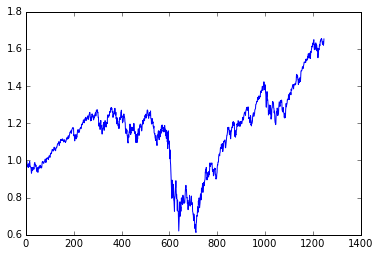

In [160]:
plt.plot(value_op_seq)
return_seq = np.log(value_op_seq[1:] / value_op_seq[:-1])
annual_return = 252 * np.mean(return_seq)
sharpe = np.sqrt(252) * np.mean(return_seq) / np.std(return_seq)
print annual_return, sharpe